In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rflearn.env import BlackJack, GridWorld, CliffGridWorld, WindGridWorld
from rflearn.algo import MCEpsilonSoft
from rflearn.utils import zero_values, random_policy

# Cliff Gridworld

In [116]:
cgrid = CliffGridWorld(4, 12)
value = zero_values(cgrid)
policy = random_policy(cgrid)

mc_model = MCEpsilonSoft(cgrid, value, policy, qvalue=None)
mc_model.fit(gamma=1, epsilon=0.1, lam=0.01, kbatch=40)

<AxesSubplot:>

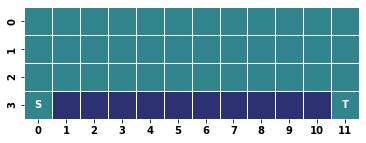

In [117]:
cgrid.plot_grid('st')

In [68]:
mc_model.transform(1500)

100%|██████████| 1500/1500 [00:46<00:00, 32.55it/s]


In [69]:
q_vals = pd.Series(mc_model.qvalue).unstack()[cgrid.A]
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
v_vals = (q_vals * pi_vals).sum(1)
np.round(v_vals.values.reshape(cgrid.shape)/10)

array([[ -4.,  -2.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -0.,  -0.],
       [ -2.,  -1.,  -1.,  -1.,  -2.,  -2.,  -1.,  -0.,  -0.,  -0.],
       [ -2.,  -2.,  -2.,  -2.,  -5., -16.,  -3.,  -2.,  -1.,  -0.],
       [ -2., -13., -15., -15., -32., -31., -24., -28., -14.,   0.]])

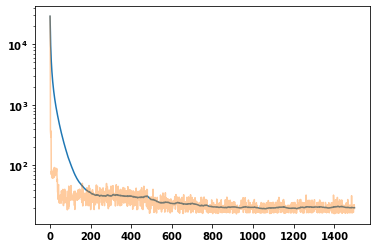

In [70]:
# pd.Series(mc_model.hist['avg_r']).plot()
(-1*pd.Series(mc_model.hist['avg_r'])).ewm(halflife=25).mean().plot(logy=True)
(-1*pd.Series(mc_model.hist['avg_r'])).plot(alpha=0.4, logy=True)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

# Gridworld MC

In [3]:
# _grid = [
#     [0, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 0],
#     [0, 0, 0, 0, 0, 0, 0],
# ]
# grid = GridWorld(grid=_grid, terminals=[0])
grid = GridWorld(4,4)
value = zero_values(grid)
policy = random_policy(grid)

mc_model = MCEpsilonSoft(grid, value, policy, qvalue=None)
mc_model.fit(gamma=1, epsilon=0.05, kbatch=30)

In [10]:
mc_model.transform(iter=100)

100%|██████████| 100/100 [00:00<00:00, 217.74it/s]


In [83]:
q_vals = pd.Series(mc_model.qvalue).unstack()[grid.A]
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
v_vals = (q_vals * pi_vals).sum(1)
np.round(v_vals.values.reshape(grid.shape))

ValueError: cannot reshape array of size 40 into shape (2,5)

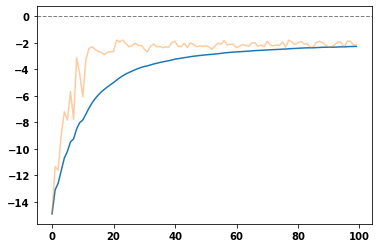

In [5]:
# pd.Series(mc_model.hist['avg_r']).plot()
pd.Series(mc_model.hist['avg_r']).ewm(halflife=25).mean().plot()
pd.Series(mc_model.hist['avg_r']).plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

In [133]:
pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]

,up,down,left,right
0,0,0,0,0
1,100,100,100,100
2,100,100,100,100
3,100,100,100,100
4,100,100,100,100
5,100,100,100,100
6,100,100,100,100
7,100,100,100,100
8,100,100,100,100
9,100,100,100,100


# Blackjack MC

In [9]:
def fix_policy(env, threshold=20):
    policy = []
    for idx in env.S:
        state = env._to_state(idx)
        if state[1] >= threshold:
            policy.append([0, 1])
        else:
            policy.append([1, 0])
    policy = np.array(policy).astype('float')
    return policy

In [10]:
game = BlackJack()
value = np.zeros(shape=len(game.S))
# policy = fix_policy(game, 20)
policy = random_policy(game)

mc_model = MCEpsilonSoft(game, value, policy)
mc_model.fit(gamma=1, epsilon=0.1, kbatch=30)

In [16]:
mc_model.transform(15000)

100%|██████████| 15000/15000 [00:57<00:00, 262.08it/s]


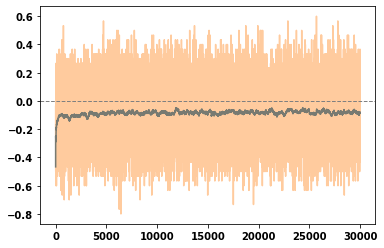

In [17]:
pd.Series(mc_model.hist['avg_r']).ewm(halflife=100).mean().plot()
pd.Series(mc_model.hist['avg_r']).plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

In [18]:
idx = pd.MultiIndex.from_tuples([s for s in game])

q_vals = pd.Series(mc_model.qvalue).unstack()[game.A]
q_vals.index = idx

pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
pi_vals.index = idx
v_vals = (q_vals * pi_vals).sum(1)

cnts = pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]
cnts.index = idx

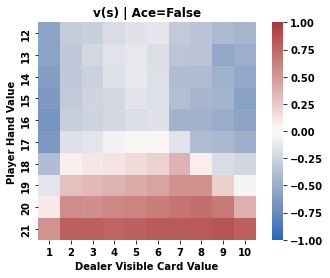

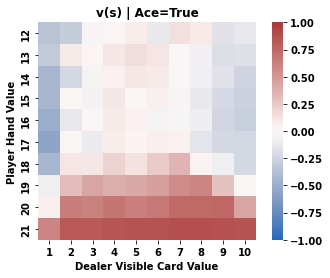

In [26]:
import seaborn as sns

d = v_vals.unstack().T
for flag in [False, True]:
    ax = sns.heatmap(d[flag].T, vmin=-1, vmax=1, center=0, square=True, cmap="vlag")
    plt.title(f'v(s) | Ace={flag}')
    plt.xlabel('Dealer Visible Card Value')
    plt.ylabel('Player Hand Value')
    plt.show()

In [28]:
cnts.unstack().T

False                                                          \
             12     13     14     15     16     17     18     19     20   
hit   1   13222  13624  14032  14426  13654    894    826    798   1158   
      2    1022  10600  11356    862    848    704    688    678    876   
      3   12826    802    690   1212    752    632    576    538    828   
      4     874    810    740    710   1156    646    516    494    826   
      5     752   1630    712    614    780    658    586    556    834   
      6     722   2774   2462    654    528    632    568    508    886   
      7   13432  11248  12896  14372    962    858    708    714   1044   
      8   13522  13712  13730  14304  14158   1716    800    864   1080   
      9   13372    836   4974  13326  12982    756    770    606   1054   
      10  38954  39566  26148   3494   6624   3158   2768   2532   3526   
stand 1    1162    868    858    958   2128  15304  14178  13806  17776   
      2   11600   2988   2200  13098  12560  12046  10914  10598  14958   
      3    1100  12340  12750  11612  12232  11198  10478   9908  14454   
      4   12982  12860  10920  12274  10862  10928   9810   8936  13766   
      5   13142  12034  12368  10734  10868  10558  10026   9264  13496   
      6   12868  10720  10220  11966   9800  10440   9900   9470  13904   
      7     820   3430   1882    854  14418  13012  12712  12266  16656   
      8     888    860    996   1128   1498  14392  13112  13746  17552   
      9     938  13986   8798    790    904  13558  12800  10894  16336   
      10   3208   3718  17062  40394  35240  37984  35258  34396  41048   

                 True                                                          
             21    12    13    14    15    16    17    18    19     20     21  
hit   1     478   310  1156  1232  1270  1610  1558   232   140    312    300  
      2     252    36  1256   130  1750  1896  1916   150   126    176    408  
      3     244   566   950  1332   492  1984   104   118   112    140    386  
      4     148   610  1588  1480  1466  2088  2242   112   218    240    404  
      5     142   624  1668  1744  1862  1294   122  2326   148    174    380  
      6     194    28  1306   872  1028   112   100  1146   442    112    442  
      7     424   618  1636  1708  1844  1976  2198   228   132    152    408  
      8     414   510  1640  1734  1782  2134  1384  2284   200    134    396  
      9     368   566  1630  1692  1962  2186  2342  2572   358    158    494  
      10   1242  2300  6480  5712  6580  7958  8634   566  3314    602   1526  
stand 1    8328    18    70    84   126    82   114  1668  1990   1926   5566  
      2    4560   576    54  1628    88   120   242  2322  2406   2578   7008  
      3    3970    50   820    56  1332   122  2072  2296  2142   2426   7084  
      4    2954    38   106   278    88   226   100  2460  2448   2574   7446  
      5    2982    58    76   104   108   704  2386   106  2526   2600   7394  
      6    3258   620   454   926   694  1948  1670  1020  1846   2334   6906  
      7    6574    42    88   104   116   138   316  2032  2740   2728   7294  
      8    8154   164    90   146   228   134  1056   470  2382   2970   7526  
      9    6158    88    82   262   118   198   110   132  2646   2588   7730  
      10  20544   108   362  1378   970   490   712  9918  7400  10564  24100